<a href="https://colab.research.google.com/github/dokunoale/chagas/blob/colloquio/notebooks/Simple_GRU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone -b dev https://github.com/dokunoale/chagas.git
!pip install -r chagas/requirements.txt

# Download the dataset
import gdown

url = "https://drive.google.com/file/d/1vK_gMI36xjdtiJjMBV7dKHurIExQs4hC/view?usp=drive_link"
gdown.download(url, "dataset.zip", quiet=False, fuzzy=True)
!unzip -q /content/dataset.zip -d chagas/data/


Cloning into 'chagas'...
remote: Enumerating objects: 542, done.
remote: Counting objects: 100% (104/104), done.
remote: Compressing objects: 100% (77/77), done.
remote: Total 542 (delta 51), reused 62 (delta 27), pack-reused 438 (from 1)
Receiving objects: 100% (542/542), 4.86 MiB | 18.70 MiB/s, done.
Resolving deltas: 100% (265/265), done.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 31.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 91.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.0/160.0 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 301.8/301.8 kB 28.1 MB/s eta 0:00:00
  Attempting uninstall: joblib
    Found existing installation: joblib 1.5.1
    Uninstalling joblib-1.5.1:
      Successfully uninstalled joblib-1.5.1
  Attempting uninstall: h5py
    Found existing installation: h5py 3.14.0
    Uninstalling h5py-3.14.0:
      Successfully uninstalled h5py-3.14.0
  Attempting uninstall: scikit-learn
   

Downloading...
From (original): https://drive.google.com/uc?id=1vK_gMI36xjdtiJjMBV7dKHurIExQs4hC
From (redirected): https://drive.google.com/uc?id=1vK_gMI36xjdtiJjMBV7dKHurIExQs4hC&confirm=t&uuid=83657855-5742-44ca-9b58-30b1394cb6ef
To: /content/dataset.zip
100%|██████████| 623M/623M [00:16<00:00, 38.7MB/s]


In [2]:
import sys
sys.path.append("/content/chagas/src")

import tensorflow as tf
from tensorflow.keras.layers import Layer
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.metrics import AUC

Caricamento del dataset e preprocessing.

In [3]:
from preprocessing.tf_dataset_loader import WfdbLoader
from preprocessing.filters import FiltfiltNoiseReducer

# Carichiamo il dataset
data_path = "/content/chagas/data/big_splitted_dataset/"

filter = FiltfiltNoiseReducer(fs=400, iir_freq=55.0, butterworth_cutoff=5., lowpass_cutoff=30., verbose=True)

train = WfdbLoader(label = 'Chagas label')
train.add_filter(filter)
train.add_filter(filter)
train.add_dataset(data_path + "train/positives")
train.add_dataset(data_path + "train/negatives")
X_train, y_train = train.load(shuffle=True, verbose=True)

validation = WfdbLoader(label = 'Chagas label')
validation.add_filter(filter)
validation.add_filter(filter)
validation.add_dataset(data_path + "val/positives")
validation.add_dataset(data_path + "val/negatives")
X_val, y_val = validation.load(shuffle=True, verbose=True)

test = WfdbLoader(label = 'Chagas label')
test.add_filter(filter)
test.add_filter(filter)
test.add_dataset(data_path + "test/positives")
test.add_dataset(data_path + "test/negatives")
X_test, y_test = test.load(shuffle=True, verbose=True)

y_test_info = test.get_metadata()

Filtering records - filtfilt: 100%|██████████| 2245/2245 [00:12<00:00, 178.92record/s]


# Training

In [5]:
def build_gru_model(
    input_shape=(2800, 12),
    gru_units=64,
    dropout_rate=0.3
):
    inputs = layers.Input(shape=input_shape, name='input_layer')  # (2800, 12)

    # Primo livello GRU bidirezionale
    x = layers.Bidirectional(
        layers.GRU(gru_units, return_sequences=True, name='gru_1'),
        name='bidirectional_gru_1'
    )(inputs)
    x = layers.Dropout(dropout_rate, name='dropout_1')(x)

    # Secondo livello GRU bidirezionale
    x = layers.Bidirectional(
        layers.GRU(gru_units, name='gru_2'),
        name='bidirectional_gru_2'
    )(x)
    x = layers.Dropout(dropout_rate, name='dropout_2')(x)

    # Dense layers
    x = layers.Dense(256, activation='relu', name='dense_1')(x)
    x = layers.Dropout(dropout_rate, name='dropout_3')(x)
    x = layers.Dense(64, activation='relu', name='dense_2')(x)

    # Output layer
    outputs = layers.Dense(1, activation='sigmoid', name='output_layer')(x)

    model = models.Model(inputs, outputs, name='ECG_GRU_Model')
    return model


# Compilazione del modello
model = build_gru_model(input_shape=(2800, 12))
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy', AUC(name='auc')]
)

model.summary()

Model: "ECG_GRU_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 2800, 12)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_gru_1             │ (None, 2800, 128)      │        29,952 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 2800, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_gru_2             │ (None, 128)            │        74,496 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 153,985 (601.50 KB)

 Trainable params: 153,985 (601.50 KB)

 Non-trainable params: 0 (0.00 B)

In [6]:
# Callback: early stopping e salvataggio del modello migliore
early_stop = EarlyStopping(monitor='val_auc', patience=6, min_delta=1e-3, mode='max', restore_best_weights=True)
checkpoint = ModelCheckpoint("best_model.keras", monitor='val_auc', mode='max', save_best_only=True)

callbacks = [early_stop, checkpoint]

# Training
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=40,
    batch_size=30,
    callbacks=callbacks
)

Epoch 1/40
262/262 ━━━━━━━━━━━━━━━━━━━━ 98s 347ms/step - accuracy: 0.5231 - auc: 0.5266 - loss: 0.6929 - val_accuracy: 0.5668 - val_auc: 0.5760 - val_loss: 0.6859
Epoch 2/40
262/262 ━━━━━━━━━━━━━━━━━━━━ 90s 344ms/step - accuracy: 0.5419 - auc: 0.5413 - loss: 0.6900 - val_accuracy: 0.5588 - val_auc: 0.5965 - val_loss: 0.6831
Epoch 3/40
262/262 ━━━━━━━━━━━━━━━━━━━━ 90s 343ms/step - accuracy: 0.5495 - auc: 0.5577 - loss: 0.6874 - val_accuracy: 0.5588 - val_auc: 0.5689 - val_loss: 0.6847
Epoch 4/40
262/262 ━━━━━━━━━━━━━━━━━━━━ 90s 343ms/step - accuracy: 0.5519 - auc: 0.5693 - loss: 0.6844 - val_accuracy: 0.5348 - val_auc: 0.5860 - val_loss: 0.6860
Epoch 5/40
262/262 ━━━━━━━━━━━━━━━━━━━━ 90s 343ms/step - accuracy: 0.5387 - auc: 0.5629 - loss: 0.6865 - val_accuracy: 0.5365 - val_auc: 0.5892 - val_loss: 0.6873
Epoch 6/40
262/262 ━━━━━━━━━━━━━━━━━━━━ 90s 343ms/step - accuracy: 0.5654 - auc: 0.5760 - loss: 0.6847 - val_accuracy: 0.5490 - val_auc: 0.5955 - val_loss: 0.6832
Epoch 7/40
262/262 ━━━

Stampa un report che riassume il modello e le sue performance

36/36 ━━━━━━━━━━━━━━━━━━━━ 6s 160ms/step
Optimal threshold: 0.450
71/71 ━━━━━━━━━━━━━━━━━━━━ 11s 152ms/step


71/71 ━━━━━━━━━━━━━━━━━━━━ 11s 152ms/step


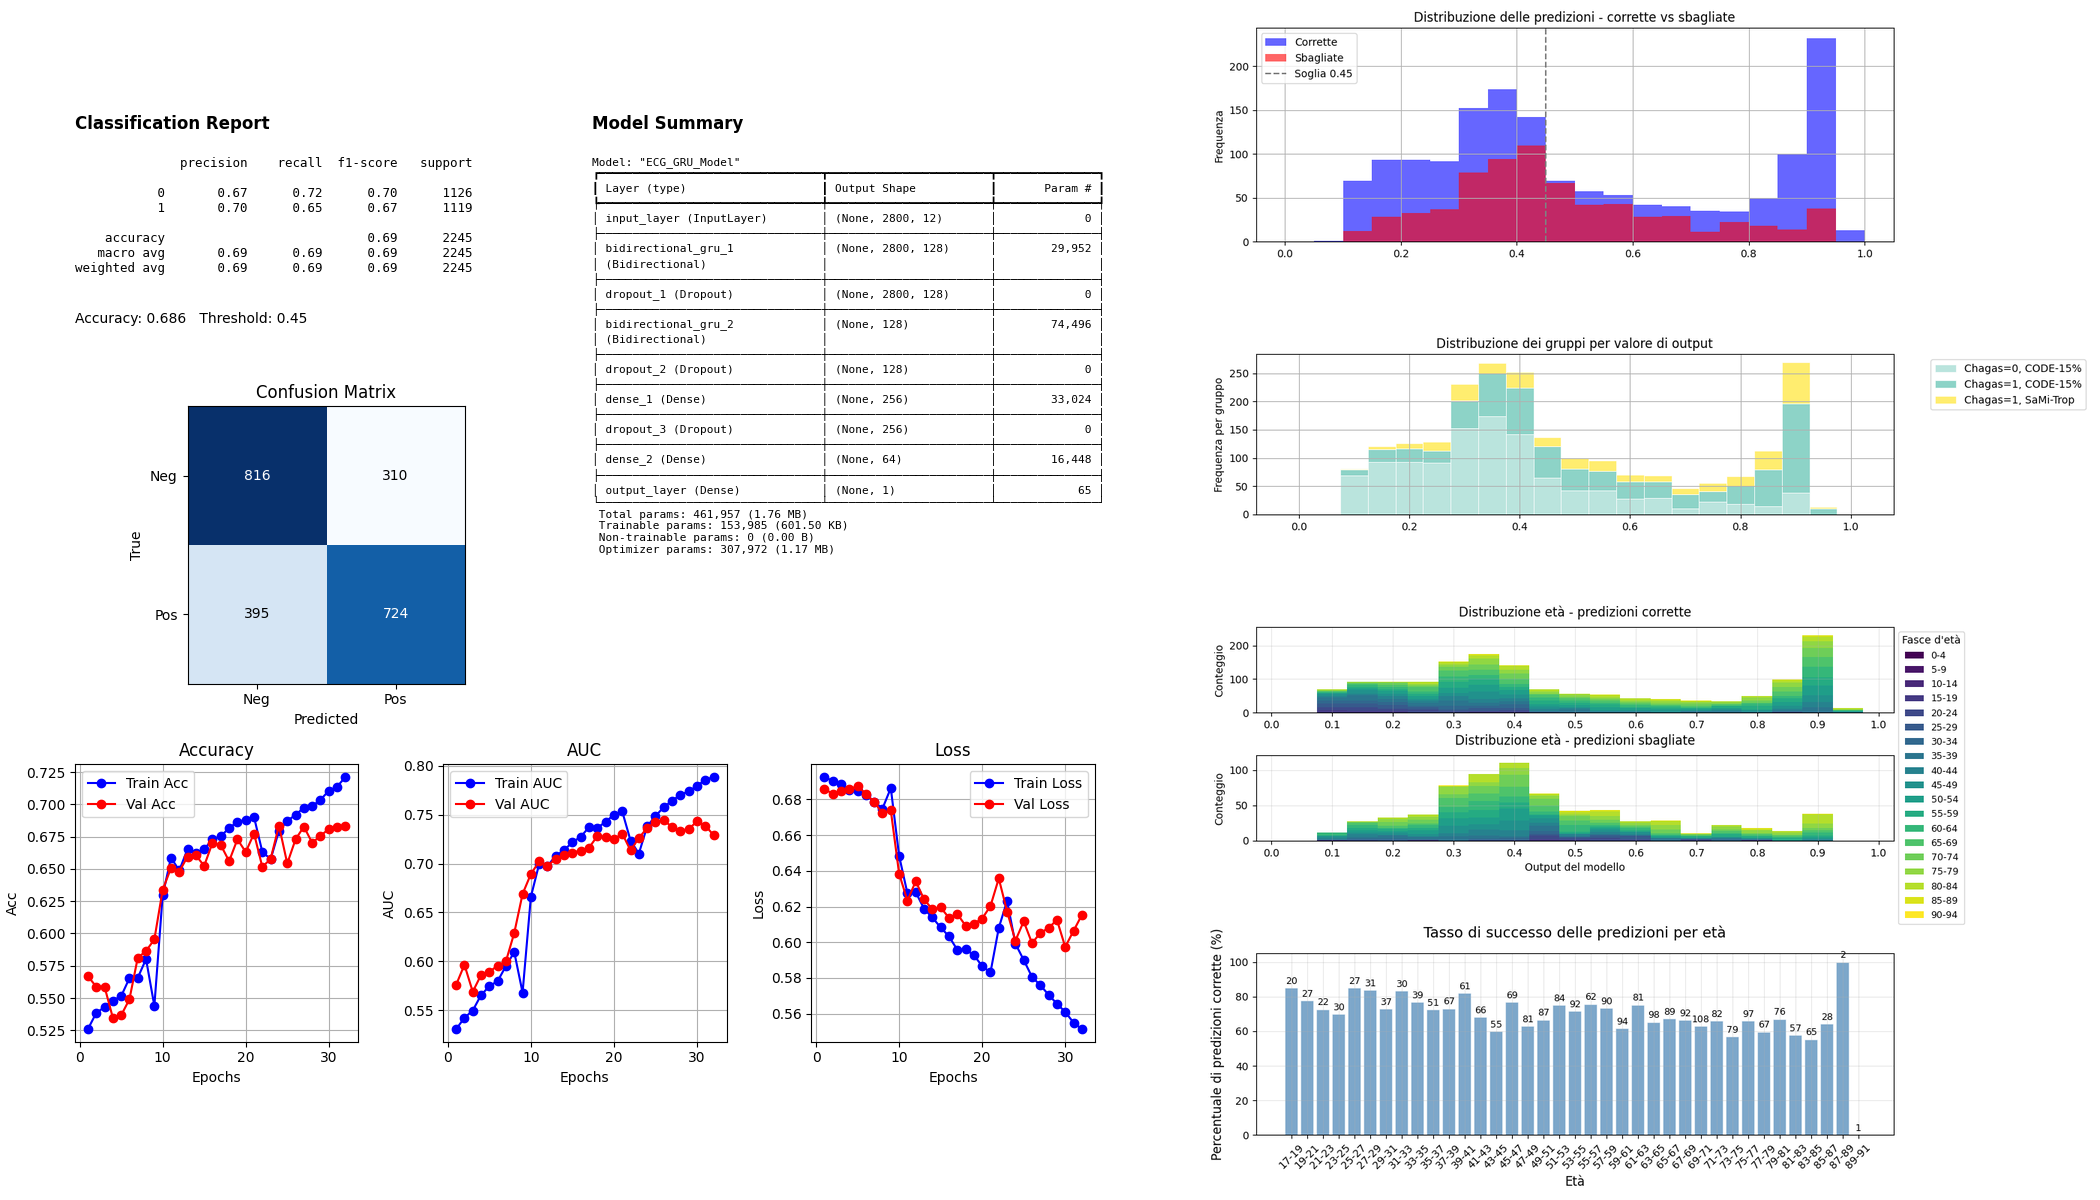

In [7]:
# NON MODIFICARE

from models.utils import find_optimal_threshold
from models.analysis import plot_full_report_and_metrics, plot_model_analysis
from PIL import Image

model = tf.keras.models.load_model("best_model.keras")

y_pred_probs = model.predict(X_val)
threshold = find_optimal_threshold(y_val, y_pred_probs)

img1 = plot_full_report_and_metrics(model, X_test, y_test, history, threshold, return_pillow=True)
img2 = plot_model_analysis(model, X_test, y_test, y_test_info, threshold, return_pillow=True)

# 1. Ridimensiona img2 all'altezza di img1, mantenendo le proporzioni
new_height = int(img1.height * 1.2)
new_width = int(img2.width * (new_height / img2.height))
img2_resized = img2.resize((new_width, new_height), Image.LANCZOS)

# 2. Calcola la nuova immagine
total_width = img1.width + img2_resized.width
max_height = max(img1.height, img2_resized.height)
new_img = Image.new('RGB', (total_width, max_height), color=(255, 255, 255))

# 3. Centra verticalmente img1 (se img1 è più bassa di max_height)
y_offset_img1 = (max_height - img1.height) // 2
y_offset_img2 = (max_height - img2_resized.height) // 2

new_img.paste(img1, (0, y_offset_img1))
new_img.paste(img2_resized, (img1.width, y_offset_img2))

# 4. Visualizza nel notebook
display(new_img)

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [9]:
model.save('/content/drive/MyDrive/chagas_models/Simple_GRU.keras')
